In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from math import *
%matplotlib inline

In [3]:
all_hits = pd.read_csv('Data/strawtubesPoint_decoded_hits.csv', delimiter=',')
all_hits['Index'] = all_hits.index
all_hits = all_hits[['Index', 'X', 'Y', 'Z', 'TrackID', 'Time', 'StatNb', 'ViewNb', 'PlaneNb', 'LayerNb', 'StrawNb', 'dist2Wire', 'event', 'k']]
all_hits.head()

,Index,X,Y,Z,TrackID,Time,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,dist2Wire,event,k
0,0,8.883409,-61.202305,-1974.859985,3,232.044861,5,0,0,0,319,0.274822,0,0
1,1,8.858191,-61.225544,-1973.742188,3,232.074081,5,0,0,1,320,0.582455,0,1
2,2,8.824563,-61.256523,-1972.251953,3,232.118286,5,0,1,0,319,0.111252,0,2
3,3,8.632817,-61.432972,-1963.756592,3,232.406479,5,1,0,1,320,0.164412,0,3
4,4,8.573978,-61.487133,-1961.149292,3,232.488541,5,1,1,1,320,0.226827,0,4


In [91]:
#для отбора хитов отдельного слоя
def selector(data, StatNb, ViewNb, PlaneNb, LayerNb):
    return data.loc[(data.StatNb==StatNb)&(data.ViewNb==ViewNb)&(data.PlaneNb==PlaneNb)&(data.LayerNb==LayerNb)]

# восстанавливает по крайним точкам отрезка коэффициент наклона и смещение
def get_plane(point1, point2):
    y1 = point1[0]
    z1 = point1[1]
    y2 = point2[0]
    z2 = point2[1]
    
    #y = kz + b
    k = float(y2 - y1)/float(z2 - z1)
    b = y1 - k*z1
    return k, b

class layer:
    def __init__(self, z, bias):
        self.bias = bias
        self.z = z
    def y(self, straw_id):
        return 499 - self.bias - straw_id * 1.76

In [5]:
def modify_for_YZ_analisys(event):    
    layer1000 = selector(event, 1, 0, 0, 0)
    layer1001 = selector(event, 1, 0, 0, 1)
    layer1010 = selector(event, 1, 0, 1, 0)
    layer1011 = selector(event, 1, 0, 1, 1)

    layer1300 = selector(event, 1, 3, 0, 0)
    layer1301 = selector(event, 1, 3, 0, 1)
    layer1310 = selector(event, 1, 3, 1, 0)
    layer1311 = selector(event, 1, 3, 1, 1)

    layer2000 = selector(event, 2, 0, 0, 0)
    layer2001 = selector(event, 2, 0, 0, 1)
    layer2010 = selector(event, 2, 0, 1, 0)
    layer2011 = selector(event, 2, 0, 1, 1)

    layer2300 = selector(event, 2, 3, 0, 0)
    layer2301 = selector(event, 2, 3, 0, 1)
    layer2310 = selector(event, 2, 3, 1, 0)
    layer2311 = selector(event, 2, 3, 1, 1)
    
    #1-y1
    z1000 = 2598. - 15. - 0.5*(2.6 - 1.1 - 0.9828) - 1.1 - 0.5*0.9828
    layer1000.loc[:, 'Wy'] = -(0.5*0.9828 + 1.76*(layer1000.StrawNb.values-1)) + 499
    layer1000.loc[:, 'Wz'] = np.ones(layer1000.shape[0])*z1000

    z1001 = z1000 + 1.1
    layer1001.loc[:, 'Wy'] = -(0.5*0.9828 - 0.88 + 1.76*(layer1001.StrawNb.values-1)) + 499
    layer1001.loc[:, 'Wz'] = np.ones(layer1001.shape[0])*z1001

    z1010 = z1000 + 2.6
    layer1010.loc[:, 'Wy'] = -(0.5*0.9828 - 0.44 + 1.76*(layer1010.StrawNb.values-1)) + 499
    layer1010.loc[:, 'Wz'] = np.ones(layer1010.shape[0])*z1010

    z1011 = z1010 + 1.1
    layer1011.loc[:, 'Wy'] = -(0.5*0.9828 - 0.44 - 0.88 + 1.76*(layer1011.StrawNb.values-1)) + 499
    layer1011.loc[:, 'Wz'] = np.ones(layer1011.shape[0])*z1011

    #1-y2
    z1300 = 2598. + 15. - 0.5*(2.6 - 1.1 - 0.9828) - 1.1 - 0.5*0.9828
    layer1300.loc[:, 'Wy'] = -(0.5*0.9828 + 1.76*(layer1300.StrawNb.values-1)) + 499
    layer1300.loc[:, 'Wz'] = np.ones(layer1300.shape[0])*z1300

    z1301 = z1300 + 1.1
    layer1301.loc[:, 'Wy'] = -(0.5*0.9828 - 0.88 + 1.76*(layer1301.StrawNb.values-1)) + 499
    layer1301.loc[:, 'Wz'] = np.ones(layer1301.shape[0])*z1301

    z1310 = z1300 + 2.6
    layer1310.loc[:, 'Wy'] = -(0.5*0.9828 - 0.44 + 1.76*(layer1310.StrawNb.values-1)) + 499
    layer1310.loc[:, 'Wz'] = np.ones(layer1310.shape[0])*z1310

    z1311 = z1310 + 1.1
    layer1311.loc[:, 'Wy'] = -(0.5*0.9828 - 0.44 - 0.88 + 1.76*(layer1311.StrawNb.values-1)) + 499
    layer1311.loc[:, 'Wz'] = np.ones(layer1311.shape[0])*z1311

    #2-y1
    z2000 = 2798. - 15. - 0.5*(2.6 - 1.1 - 0.9828) - 1.1 - 0.5*0.9828
    layer2000.loc[:, 'Wy'] = -(0.5*0.9828 + 1.76*(layer2000.StrawNb.values-1)) + 499
    layer2000.loc[:, 'Wz'] = np.ones(layer2000.shape[0])*z2000

    z2001 = z2000 + 1.1
    layer2001.loc[:, 'Wy'] = -(0.5*0.9828 - 0.88 + 1.76*(layer2001.StrawNb.values-1)) + 499
    layer2001.loc[:, 'Wz'] = np.ones(layer2001.shape[0])*z2001

    z2010 = z2000 + 2.6
    layer2010.loc[:, 'Wy'] = -(0.5*0.9828 - 0.44 + 1.76*(layer2010.StrawNb.values-1)) + 499
    layer2010.loc[:, 'Wz'] = np.ones(layer2010.shape[0])*z2010

    z2011 = z2010 + 1.1
    layer2011.loc[:, 'Wy'] = -(0.5*0.9828 - 0.44 - 0.88 + 1.76*(layer2011.StrawNb.values-1)) + 499
    layer2011.loc[:, 'Wz'] = np.ones(layer2011.shape[0])*z2011

    #2-y2
    z2300 = 2798. + 15. - 0.5*(2.6 - 1.1 - 0.9828) - 1.1 - 0.5*0.9828
    layer2300.loc[:, 'Wy'] = -(0.5*0.9828 + 1.76*(layer2300.StrawNb.values-1)) + 499
    layer2300.loc[:, 'Wz'] = np.ones(layer2300.shape[0])*z2300

    z2301 = z2300 + 1.1
    layer2301.loc[:, 'Wy'] = -(0.5*0.9828 - 0.88 + 1.76*(layer2301.StrawNb.values-1)) + 499
    layer2301.loc[:, 'Wz'] = np.ones(layer2301.shape[0])*z2301

    z2310 = z2300 + 2.6
    layer2310.loc[:, 'Wy'] = -(0.5*0.9828 - 0.44 + 1.76*(layer2310.StrawNb.values-1)) + 499
    layer2310.loc[:, 'Wz'] = np.ones(layer2310.shape[0])*z2310

    z2311 = z2310 + 1.1
    layer2311.loc[:, 'Wy'] = -(0.5*0.9828 - 0.44 - 0.88 + 1.76*(layer2311.StrawNb.values-1)) + 499
    layer2311.loc[:, 'Wz'] = np.ones(layer2311.shape[0])*z2311
    
    layers = [layer1000, layer1001, layer1010, layer1011,
              layer1300, layer1301, layer1310, layer1311,
              layer2000, layer2001, layer2010, layer2011,
              layer2300, layer2301, layer2310, layer2311]

    return pd.concat(layers, axis=0)

In [6]:
def modify_for_XZ_analisys(event):    
    layer1100 = selector(event, 1, 1, 0, 0)
    layer1101 = selector(event, 1, 1, 0, 1)
    layer1110 = selector(event, 1, 1, 1, 0)
    layer1111 = selector(event, 1, 1, 1, 1)

    layer1200 = selector(event, 1, 2, 0, 0)
    layer1201 = selector(event, 1, 2, 0, 1)
    layer1210 = selector(event, 1, 2, 1, 0)
    layer1211 = selector(event, 1, 2, 1, 1)

    layer2100 = selector(event, 2, 1, 0, 0)
    layer2101 = selector(event, 2, 1, 0, 1)
    layer2110 = selector(event, 2, 1, 1, 0)
    layer2111 = selector(event, 2, 1, 1, 1)

    layer2200 = selector(event, 2, 2, 0, 0)
    layer2201 = selector(event, 2, 2, 0, 1)
    layer2210 = selector(event, 2, 2, 1, 0)
    layer2211 = selector(event, 2, 2, 1, 1)
    
    #1-u
    z1100 = 2598. - 5. - 0.25*(2.6 - 1.1 - 0.9828) - 1.1 - 0.5*0.9828
    layer1100.loc[:, 'dist2Centre'] = -(0.5*0.9828 + 1.76*(layer1100.StrawNb.values-1)) + 499
    layer1100.loc[:, 'Wz'] = np.ones(layer1100.shape[0])*z1100

    z1101 = z1100 + 1.1
    layer1101.loc[:, 'dist2Centre'] = -(0.5*0.9828 - 0.88 + 1.76*(layer1101.StrawNb.values-1)) + 499
    layer1101.loc[:, 'Wz'] = np.ones(layer1101.shape[0])*z1101

    z1110 = z1100 + 2.6
    layer1110.loc[:, 'dist2Centre'] = -(0.5*0.9828 - 0.44 + 1.76*(layer1110.StrawNb.values-1)) + 499
    layer1110.loc[:, 'Wz'] = np.ones(layer1110.shape[0])*z1110

    z1111 = z1110 + 1.1
    layer1111.loc[:, 'dist2Centre'] = -(0.5*0.9828 - 0.44 - 0.88 + 1.76*(layer1111.StrawNb.values-1)) + 499
    layer1111.loc[:, 'Wz'] = np.ones(layer1111.shape[0])*z1111

    #1-v
    z1200 = 2598. + 5. - 0.25*(2.6 - 1.1 - 0.9828) - 1.1 - 0.5*0.9828
    layer1200.loc[:, 'dist2Centre'] = -(0.5*0.9828 + 1.76*(layer1200.StrawNb.values-1)) + 499
    layer1200.loc[:, 'Wz'] = np.ones(layer1200.shape[0])*z1200
    
    z1201 = z1200 + 1.1
    layer1201.loc[:, 'dist2Centre'] = -(0.5*0.9828 - 0.88 + 1.76*(layer1201.StrawNb.values-1)) + 499
    layer1201.loc[:, 'Wz'] = np.ones(layer1201.shape[0])*z1201

    z1210 = z1200 + 2.6
    layer1210.loc[:, 'dist2Centre'] = -(0.5*0.9828 - 0.44 + 1.76*(layer1210.StrawNb.values-1)) + 499
    layer1210.loc[:, 'Wz'] = np.ones(layer1210.shape[0])*z1210

    z1211 = z1210 + 1.1
    layer1211.loc[:, 'dist2Centre'] = -(0.5*0.9828 - 0.44 - 0.88 + 1.76*(layer1211.StrawNb.values-1)) + 499
    layer1211.loc[:, 'Wz'] = np.ones(layer1211.shape[0])*z1211

    #2-u
    z2100 = 2798. - 5. - 0.25*(2.6 - 1.1 - 0.9828) - 1.1 - 0.5*0.9828
    layer2100.loc[:, 'dist2Centre'] = -(0.5*0.9828 + 1.76*(layer2100.StrawNb.values-1)) + 499
    layer2100.loc[:, 'Wz'] = np.ones(layer2100.shape[0])*z2100

    z2101 = z2100 + 1.1
    layer2101.loc[:, 'dist2Centre'] = -(0.5*0.9828 - 0.88 + 1.76*(layer2101.StrawNb.values-1)) + 499
    layer2101.loc[:, 'Wz'] = np.ones(layer2101.shape[0])*z2101

    z2110 = z2100 + 2.6
    layer2110.loc[:, 'dist2Centre'] = -(0.5*0.9828 - 0.44 + 1.76*(layer2110.StrawNb.values-1)) + 499
    layer2110.loc[:, 'Wz'] = np.ones(layer2110.shape[0])*z2110

    z2111 = z2110 + 1.1
    layer2111.loc[:, 'dist2Centre'] = -(0.5*0.9828 - 0.44 - 0.88 + 1.76*(layer2111.StrawNb.values-1)) + 499
    layer2111.loc[:, 'Wz'] = np.ones(layer2111.shape[0])*z2111

    #2-v
    z2200 = 2798. + 5. - 0.25*(2.6 - 1.1 - 0.9828) - 1.1 - 0.5*0.9828
    layer2200.loc[:, 'dist2Centre'] = -(0.5*0.9828 + 1.76*(layer2200.StrawNb.values-1)) + 499
    layer2200.loc[:, 'Wz'] = np.ones(layer2200.shape[0])*z2200

    z2201 = z2200 + 1.1
    layer2201.loc[:, 'dist2Centre'] = -(0.5*0.9828 - 0.88 + 1.76*(layer2201.StrawNb.values-1)) + 499
    layer2201.loc[:, 'Wz'] = np.ones(layer2201.shape[0])*z2201

    z2210 = z2200 + 2.6
    layer2210.loc[:, 'dist2Centre'] = -(0.5*0.9828 - 0.44 + 1.76*(layer2210.StrawNb.values-1)) + 499
    layer2210.loc[:, 'Wz'] = np.ones(layer2210.shape[0])*z2210

    z2211 = z2210 + 1.1
    layer2211.loc[:, 'dist2Centre'] = -(0.5*0.9828 - 0.44 - 0.88 + 1.76*(layer2211.StrawNb.values-1)) + 499
    layer2211.loc[:, 'Wz'] = np.ones(layer2211.shape[0])*z2211
    
    layers = [layer1100, layer1101, layer1110, layer1111,
              layer1200, layer1201, layer1210, layer1211,
              layer2100, layer2101, layer2110, layer2111,
              layer2200, layer2201, layer2210, layer2211]

    return pd.concat(layers, axis=0)

In [109]:
class parametresYZ:
    def __init__(self, y, dist2Wire, index):
        self.dist2Wire = dist2Wire
        self.y = y
        self.index = index

def conventorYZ(event):
    event = modify_for_YZ_analisys(event)
    dictionary = {}
    for i in event.Wz.values:
        dictionary[i] = []
    for i in event.index:
        dictionary[event.Wz[i]].append(parametresYZ(event.Wy[i], event.dist2Wire[i], event.Index[i]))
    return dictionary

class parametresXZ:
    def __init__(self, dist2Centre, dist2Wire, angle, index):
        self.dist2Centre = dist2Centre
        self.dist2Wire = dist2Wire
        self.angle = angle
        self.index = index

def conventorXZ(event):
    event = modify_for_XZ_analisys(event)
    dictionary = {}
    for i in event.Wz.values:
        dictionary[i] = []
    for i in event.index:
        dictionary[event.Wz[i]].append(parametresXZ(event.dist2Centre[i], event.dist2Wire[i], (-(event.ViewNb[i] - 2) * 2 + 1) * np.pi / 36, event.Index[i]))
    return dictionary

In [224]:
def points_crossing_lineYZ(plane_k, plane_b, plane_width, hits, n_min):
    lower_y = 0.
    upper_y = 0.
    crossing_points = []
    Y = [] # for linnear regression
    Z = []
    n = 0 # number of touched layers
    for i in hits.keys():
        #lower_y = plane_k * i + plane_b - 1. * plane_width / np.cos(np.arctan(plane_k))
        #upper_y = plane_k * i + plane_b + 1. * plane_width / np.cos(np.arctan(plane_k))
        lower_y = plane_k * i + plane_b - 1. * plane_width
        upper_y = plane_k * i + plane_b + 1. * plane_width
        a = False
        for j in hits[i]:
            if ((j.y < upper_y) & (j.y > lower_y)):
                crossing_points.append(j.index)
                Z.append(i)
                Y.append(j.y)
                a = True
        if a: n += 1
    
    if n < n_min:
        return 0, crossing_points, [0., 0.]
    else:
        lin_regr = np.polyfit(Z, Y, 1)
        return 1, crossing_points, lin_regr

def points_crossing_lineXZ(k, b, width, hits, n_min):
    lower_x = 0.
    upper_x = 0.
    crossing_points = []
    X = [] # for linnear regression
    Z = []
    n = 0 # number of touched layers
    for i in hits.keys():
        lower_x = k * i + b - 1. * width
        upper_x = k * i + b + 1. * width
        a = False
        for j in hits[i]:
            if ((j[0] < upper_x) & (j[0] > lower_x)):
                crossing_points.append(j[2])
                Z.append(i)
                X.append(j[0])
                a = True
        if a: n += 1
    
    if n < n_min:
        return 0, crossing_points, [0., 0.]
    else:
        lin_regr = np.polyfit(Z, X, 1)
        return 1, crossing_points, lin_regr

In [204]:
def loopYZ(event, n_min, plane_width):
    hits = conventorYZ(event) # dictionary with hits: key = z; value = array of objects with fields(y, dist2Wire, index)
    tracks = {} #finded tracks: key = id of recognized track; value = (k, p)
    linking_table = {} # key = id of recognized track; value = array of hit ID's from the main table
    trackID = 1
    start_layer = layer(2581.15, 0.5*0.9828)
    end_layer = l2311 = layer(2815.95, 0.5*0.9828 - 0.44 - 0.88)
    start_y = []
    start_z = start_layer.z
    end_y = []
    end_z = end_layer.z
    for i in range(567):
        start_y += [start_layer.y(i),]
        end_y += [end_layer.y(i),]
    for i in start_y:
        for j in end_y:
            k, b = get_plane((i, start_z), (j, end_z))
            indicator, crossing_points, lin_regr = points_crossing_lineYZ(k, b, plane_width, hits, n_min)
            if indicator == 1:
                tracks[trackID] = lin_regr
                linking_table[trackID] = crossing_points
                trackID += 1
    return tracks, linking_table

In [222]:
def loopXZ(event, tracks, linking_table, n_min, width):
    hits = conventorXZ(event)
    coeff = 1 / sin(np.pi / 36)
    new_linking_table = {}
    new_tracks = {}
    new_trackID = 1
    x_points = [((i * 1.76 + 0.5 * 0.9828) * coeff - 250) for i in range(25)]
    start_z = 2591.2793
    end_z = 2806.0793000000003
    for track_key in tracks.keys():
        k = tracks[track_key][0]
        b = tracks[track_key][1]
        hits_loc = {}
        n = 0
        for z in hits.keys():
            y = k * z + b
            hits_loc[z] = []
            for hit in hits[z]:
                x = y / tan(- hit.angle) - hit.dist2Centre / sin(- hit.angle)
                if ((x > -250) & (x < 250)):
                    hits_loc[z].append((x, hit.dist2Wire, hit.index))
                    n += 1
        if (n >= n_min):
            for i in x_points:
                for j in x_points:
                    k, b = get_plane((i, start_z), (j, end_z))
                    indicator, crossing_points, lin_regr = points_crossing_lineXZ(k, b, width, hits_loc, n_min)
                    if indicator == 1:
                        new_tracks[track_key * 1000 + new_trackID] = lin_regr
                        new_linking_table[track_key * 1000 + new_trackID] = crossing_points
                        new_trackID += 1
    return new_tracks, new_linking_table

In [159]:
event0 = all_hits[all_hits['event']==2]
set(event0['TrackID'])

{2.0, 3.0}

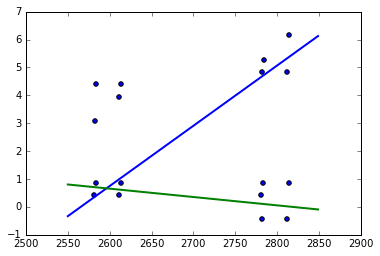

In [206]:
plt.scatter(modify_for_YZ_analisys(event0)['Wz'], modify_for_YZ_analisys(event0)['Wy'])
t = np.arange(2550, 2850, 299)
for i in tracks.keys():
    plt.plot(t, tracks[i][0] * t + tracks[i][1], lw = 2)

In [205]:
tracks, linking_table = loopYZ(event0, 7, 0.85)

In [225]:
new_tracks, new_linking_table = loopXZ(event0, tracks, linking_table, 6, 15)

In [189]:
hits = conventorXZ(event0)
coeff = 1 / sin(np.pi / 36)
new_linking_table = {}
new_tracks = {}
new_trackID = 1
x_points = [((i * 1.76 / 2 + 0.5 * 0.9828) * coeff - 250) for i in range(50)]
start_z = 2591.2793
end_z = 2806.0793000000003
track_key = 1
k = tracks[track_key][0]
b = tracks[track_key][1]
hits_loc = {}
n = 0
for z in hits.keys():
    y = k * z + b
    hits_loc[z] = []
    for hit in hits[z]:
        x = y / tan(- hit.angle) - hit.dist2Centre / sin(- hit.angle)
        if ((x > -250) & (x < 250)):
            hits_loc[z].append((x, hit.dist2Wire, hit.index))
            n += 1

In [190]:
xs = []
zs = []
for i in hits_loc.keys():
    for j in hits_loc[i]:
        zs.append(i)
        xs.append(j[0])

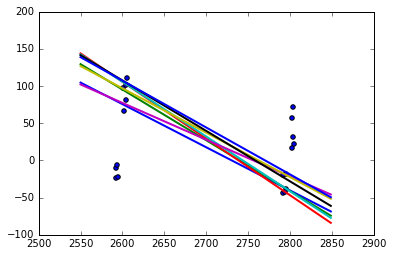

In [227]:
plt.scatter(zs, xs)
t = np.arange(2550, 2850, 299)
for i in new_tracks.keys():
    plt.plot(t, new_tracks[i][0] * t + new_tracks[i][1], lw = 2)

In [226]:
new_tracks

{1001: array([ -5.79314357e-01,   1.58186406e+03]),
 1002: array([ -6.81227682e-01,   1.86649785e+03]),
 1003: array([ -7.61783228e-01,   2.08637670e+03]),
 1004: array([ -7.34671301e-01,   2.01582217e+03]),
 2005: array([ -4.94452522e-01,   1.36290345e+03]),
 2006: array([ -5.96236069e-01,   1.64717563e+03]),
 2007: array([ -6.77149013e-01,   1.86805587e+03]),
 2008: array([ -6.29616072e-01,   1.74428893e+03])}